## Finetuning MORPH on [ICF data](https://github.com/LLNL/macc)

In [1]:
# install required packages to download from Hugging Face Hub
%pip -q install huggingface_hub
%pip install hf_xet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# install required packages to get notebook path
%pip install ipynbname --quiet

Note: you may need to restart the kernel to use updated packages.


#### Set-up directories

In [3]:
# Set cwd to the directory 
import os
from pathlib import Path
import ipynbname

HERE = Path(ipynbname.path()).resolve().parent
ROOT = HERE.parents[1]
os.chdir(HERE)
print("Current directory: ", os.getcwd())
os.chdir(ROOT)
print("Root directory:", os.getcwd())

Current directory:  F:\FM\codes\github_version\MORPH\experiments\ft_llnl_jag
Root directory: F:\FM\codes\github_version\MORPH


In [4]:
# Define important directories
dataset_dir = os.path.join(ROOT, "datasets")
data_dir = os.path.join(ROOT, "data")
model_dir = os.path.join(ROOT, "models")
results_dir = os.path.join(ROOT, "experiments", "results")
print("Dataset directory:", dataset_dir)
print("Data directory:", data_dir)
print("Model directory:", model_dir)
print("Results directory:", results_dir)

Dataset directory: F:\FM\codes\github_version\MORPH\datasets
Data directory: F:\FM\codes\github_version\MORPH\data
Model directory: F:\FM\codes\github_version\MORPH\models
Results directory: F:\FM\codes\github_version\MORPH\experiments\results


#### Load ICF dataset

In [5]:
# Load ICF-JAG-10K dataset
import os, numpy as np

path_images = os.path.join(HERE, "icf-jag-10k", "jag10K_images.npy")
path_params = os.path.join(HERE, "icf-jag-10k", "jag10K_params.npy")
path_scalars = os.path.join(HERE, "icf-jag-10k", "jag10K_0_scalars.npy")

images = np.load(path_images, allow_pickle=False).astype(np.float32)
params = np.load(path_params, allow_pickle=False).astype(np.float32)
scalars = np.load(path_scalars, allow_pickle=False).astype(np.float32)

print("images.shape:", images.shape)
print("params.shape:", params.shape)
print("scalars.shape:", scalars.shape)

images.shape: (10000, 16384)
params.shape: (10000, 5)
scalars.shape: (10000, 15)


#### Data stats

In [6]:
# some stats
min_images, max_images = images.min(), images.max()
mean_images, std_images = images.mean(), images.std()
print(f"images: min {min_images}, max {max_images}, mean {mean_images}, std {std_images}")

min_params, max_params = params.min(), params.max()
mean_params, std_params = params.mean(), params.std()
print(f"params: min {min_params}, max {max_params}, mean {mean_params}, std {std_params}")

min_scalars, max_scalars = scalars.min(), scalars.max()
mean_scalars, std_scalars = scalars.mean(), scalars.std()
print(f"scalars: min {min_scalars}, max {max_scalars}, mean {mean_scalars}, std {std_scalars}")

images: min 0.0, max 255.50160217285156, mean 1.0018655061721802, std 4.399370193481445
params: min -0.29999399185180664, max 0.9999943971633911, mean 0.2000970095396042, std 0.33403918147087097
scalars: min 0.0005003230180591345, max 0.9914026856422424, mean 0.30184993147850037, std 0.20122858881950378


#### Data visualizations

##### Scalars and Parameters

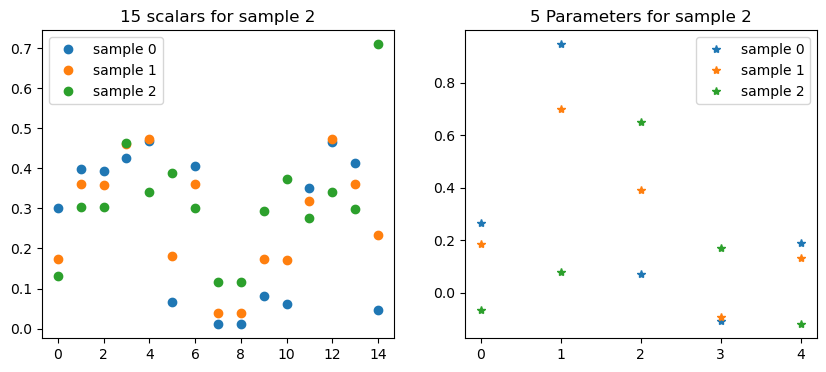

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1,2,1)
    plt.plot(scalars[i,:],'o', label =f'sample {i}')
    plt.title(f'{scalars.shape[1]} scalars for sample {i}')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(params[i,:],'*', label =f'sample {i}')
    plt.title(f'{params.shape[1]} Parameters for sample {i}')
    plt.legend()

In [ ]:
# Visualize the scalars
import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)

for i in range(15):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    ax.hist(scalars[:, i], bins=50, alpha=0.7)
    ax.set_title(f'Scalar {i+1}', fontsize=14)
    ax.set_xlabel('Value', fontsize=14)
    if c == 0:
        ax.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

##### Images

Reshaped images: (10000, 64, 64, 4)


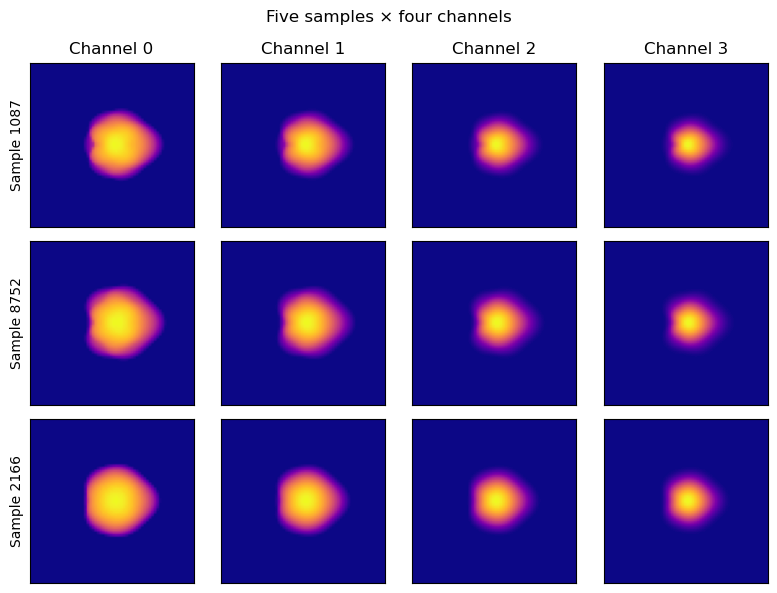

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# If not already reshaped:
images_reshape = images.reshape(images.shape[0], 64, 64, 4).astype(np.float32)
print(f"Reshaped images: {images_reshape.shape}")  # (N, 64, 64, 4)

# pick 5 unique samples
idxs = np.random.choice(images_reshape.shape[0], 3, replace=False)

fig, axes = plt.subplots(len(idxs), 4, figsize=(8, 2*len(idxs)))

# handle the case axes is 2D
for r, idx in enumerate(idxs):
    for c in range(4):
        ax = axes[r, c]
        ax.imshow(images_reshape[idx, :, :, c], cmap='plasma', origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f'Channel {c}')
        if c == 0:
            ax.set_ylabel(f'Sample {idx}')

plt.suptitle('Five samples × four channels')
plt.tight_layout()
plt.show()

### Sensitivity analysis

#### Capturing sensitivity of images and params

##### PCA of images

In [9]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA   
import matplotlib.pyplot as plt

N,H,W,C = images_reshape.shape
X = images_reshape.reshape(N, -1).astype(np.float32)
Y = params.astype(np.float32)
S = scalars.astype(np.float32)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}, S.shape: {S.shape}")

# standardize X and Y for comparable coefficient scales
X = (X - X.mean(0)) / (X.std(0) + 1e-8)
Yz = (Y - Y.mean(0)) / (Y.std(0) + 1e-8)
Sz = (S - S.mean(0)) / (S.std(0) + 1e-8)

# --- NEW: PCA compress images to PCA components ---
pca_components = 32
pca = PCA(n_components=pca_components, svd_solver="randomized", random_state=0)
Z = pca.fit_transform(X)                    # (N, 10) PCA scores per image
Zz = (Z - Z.mean(0)) / (Z.std(0) + 1e-8)    # standardize PC scores

print("Z.shape (PC scores):", Z.shape)
print("Explained variance (first 8):", pca.explained_variance_ratio_.sum())

X.shape: (10000, 16384), Y.shape: (10000, 5), S.shape: (10000, 15)
Z.shape (PC scores): (10000, 32)
Explained variance (first 8): 0.9930927


##### Ridge regression for sensitivity of input (images) on ouputs (params)

coef.shape (PC x param): (32, 5)


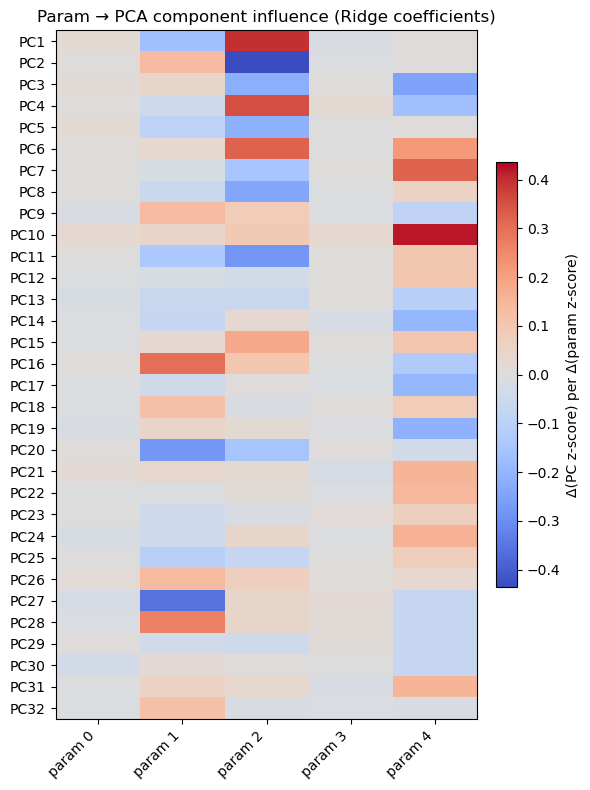

In [10]:
# sensitivity analysis as the ratio of output (images) to inputs (params)
reg = Ridge(alpha=1.0, solver="lsqr")
reg.fit(Yz, Zz)

coef = reg.coef_   # (pca_components, 5): each row = PCA, each col = param
print("coef.shape (PC x param):", coef.shape)

# plot influence heatmap (signed effects)
param_names = [f"param {i}" for i in range(Y.shape[1])]
pc_names = [f"PC{i+1}" for i in range(pca_components)]

v = np.max(np.abs(coef))
plt.figure(figsize=(6, 8))
im = plt.imshow(coef, aspect="auto", cmap="coolwarm", vmin=-v, vmax=v)
plt.xticks(range(len(param_names)), param_names, rotation=45, ha="right")
plt.yticks(range(len(pc_names)), pc_names)
plt.title("Param → PCA component influence (Ridge coefficients)")
plt.colorbar(im, fraction=0.046, pad=0.04, label="Δ(PC z-score) per Δ(param z-score)")
plt.tight_layout()
plt.show()

##### Ridge regression for sensitivity of inputs and scalars on outputs (params)

coef.shape (param x features): (5, 47)


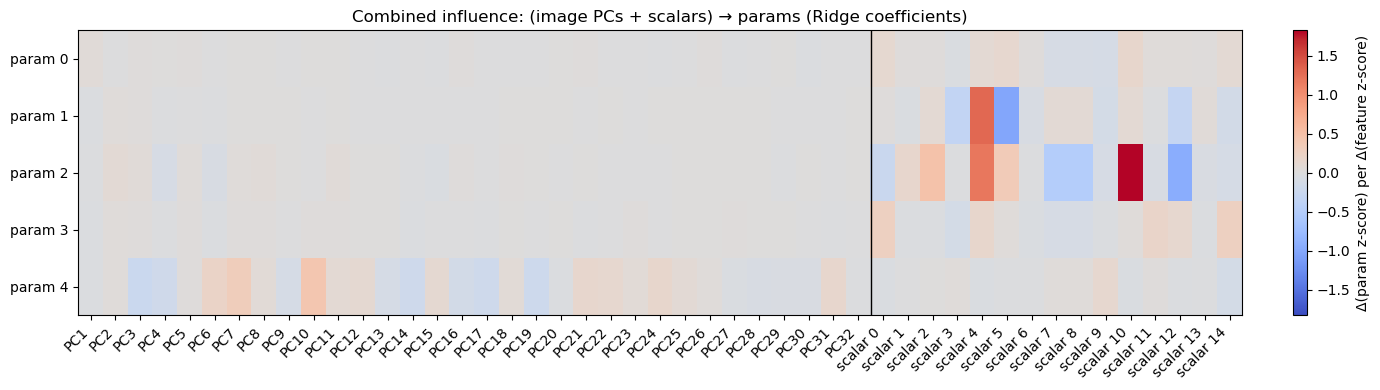

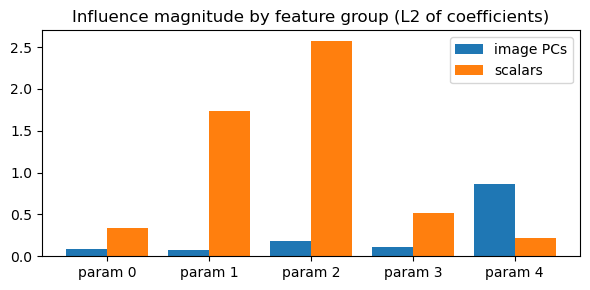

In [11]:
# combine features: [PCs | scalars]
F = np.concatenate([Zz, Sz], axis=1)           # (N, 16+15)

# standardize targets (params)
Yz = (Y - Y.mean(0)) / (Y.std(0) + 1e-8)

# fit: (images PCs + scalars) -> params
reg = Ridge(alpha=1.0, solver="lsqr")
reg.fit(F, Yz)

coef = reg.coef_   # (5, 31): rows=params, cols=[PC1..PC16 | scalar0..scalar14]
print("coef.shape (param x features):", coef.shape)

# --- plot coefficient heatmap ---
param_names = [f"param {i}" for i in range(Y.shape[1])]
feat_names = [f"PC{i+1}" for i in range(pca_components)] + [f"scalar {i}" for i in range(S.shape[1])]

v = np.max(np.abs(coef))
plt.figure(figsize=(14, 4))
im = plt.imshow(coef, aspect="auto", cmap="coolwarm", vmin=-v, vmax=v)
plt.xticks(range(len(feat_names)), feat_names, rotation=45, ha="right")
plt.yticks(range(len(param_names)), param_names)
plt.axvline(pca_components - 0.5, color="k", linewidth=1)  # split PCs vs scalars
plt.title("Combined influence: (image PCs + scalars) → params (Ridge coefficients)")
plt.colorbar(im, fraction=0.046, pad=0.04, label="Δ(param z-score) per Δ(feature z-score)")
plt.tight_layout()
plt.show()

# --- summarize how much each group contributes per param ---
pc_infl = np.linalg.norm(coef[:, :pca_components], axis=1)
sc_infl = np.linalg.norm(coef[:, pca_components:], axis=1)

plt.figure(figsize=(6, 3))
x = np.arange(len(param_names))
plt.bar(x - 0.2, pc_infl, width=0.4, label="image PCs")
plt.bar(x + 0.2, sc_infl, width=0.4, label="scalars")
plt.xticks(x, param_names)
plt.title("Influence magnitude by feature group (L2 of coefficients)")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# --- R2 comparison ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
import numpy as np

def r2_per_param(F, Yz, alpha=1.0):
    Ftr, Fte, Ytr, Yte = train_test_split(F, Yz, test_size=0.2, random_state=0)
    reg = Ridge(alpha=alpha, solver="lsqr")
    reg.fit(Ftr, Ytr)
    Ypred = reg.predict(Fte)
    return np.array([r2_score(Yte[:,j], Ypred[:,j]) for j in range(Yz.shape[1])])

F_both = np.concatenate([Zz, Sz], axis=1)

r2_pc   = r2_per_param(Zz, Yz)
r2_sc   = r2_per_param(Sz, Yz)
r2_both = r2_per_param(F_both, Yz)

print("R2 PCs only:     ", r2_pc)
print("R2 scalars only: ", r2_sc)
print("R2 both:         ", r2_both)
print("ΔR2 (add PCs on top of scalars):", r2_both - r2_sc)
print("ΔR2 (add scalars on top of PCs):", r2_both - r2_pc)

R2 PCs only:      [-0.00799237  0.55393397  0.92867222 -0.00728439  0.72056775]
R2 scalars only:  [-1.83460907e-05  9.97415964e-01  9.92450530e-01  2.86822576e-03
 -1.78274943e-03]
R2 both:          [-0.01088033  0.99774957  0.99533288 -0.00416223  0.72034269]
ΔR2 (add PCs on top of scalars): [-1.08619826e-02  3.33607833e-04  2.88235063e-03 -7.03045599e-03
  7.22125442e-01]
ΔR2 (add scalars on top of PCs): [-2.88795872e-03  4.43815597e-01  6.66606573e-02  3.12216100e-03
 -2.25055670e-04]


### Data Normalization
- We perform Reverse Instance Normalization (ReVIN) [Paper](https://openreview.net/forum?id=cGDAkQo1C0p).
- For every (Sample, Field), it calculates ($\mu$,$\sigma$)
- After training, ($\mu$,$\sigma$) can be used for denormalization

##### Images

In [13]:
# Data in (N, T, D, H, W, C, F) format
E_1 = images_reshape[:, :, :, 0]
E_2 = images_reshape[:, :, :, 1]
E_3 = images_reshape[:, :, :, 2]
E_4 = images_reshape[:, :, :, 3]

# Organize data into components
E_12 = np.stack((E_1, E_2), axis=-1)[..., np.newaxis]  # (N, H, W, C, F) -> (N, 64, 64, 2, 1)
E_34 = np.stack((E_3, E_4), axis=-1)[..., np.newaxis]  # (N, H, W, C, F) -> (N, 64, 64, 2, 1)
E_13 = np.stack((E_1, E_3), axis=-1)[..., np.newaxis]  # (N, 64, 64, 2, 1)
E_24 = np.stack((E_2, E_4), axis=-1)[..., np.newaxis]  # (N, 64, 64, 2, 1)

# Organize data into fields and components
# type - 1 where E12 and E34 are groups as fields 
data_1 = np.concatenate((E_12, E_34), axis=-1)  # (N, 64, 64, 2, 2)
print(f"Organized data shape (type-1): {data_1.shape}")  # (N, 64, 64, 2, 2)

# type - 2 where E13 and E24 are groups as fields
data_2 = np.concatenate((E_13, E_24), axis=-1)  # (N, 64, 64, 2, 2)
print(f"Organized data shape (type-2): {data_2.shape}")  # (N, 64, 64, 2, 2)

# type - 3 where all are fields
data_3 = images_reshape.reshape(N, H, W, 1, C)  
print(f"Organized data shape (type-3): {data_3.shape}")

data  = data_3  # choose one organization
print(f"Final data shape (N,H,W,C,F): {data.shape}")  # (N, 64, 64, 2, 2)


Organized data shape (type-1): (10000, 64, 64, 2, 2)
Organized data shape (type-2): (10000, 64, 64, 2, 2)
Organized data shape (type-3): (10000, 64, 64, 1, 4)
Final data shape (N,H,W,C,F): (10000, 64, 64, 1, 4)


In [14]:
# Bring data into (N, T, D, H, W, C, F) format
data = data[:, np.newaxis, np.newaxis, :, :, :, :]  
print(f"Data shape (N, T, D, H, W, F, C): {data.shape}")  

# Reshape the data in UPTF-7 format
data = data.transpose(0, 1, 6, 5, 2, 3, 4)  
print(f"Data shape (N, T, F, C, D, H, W): {data.shape}")  

Data shape (N, T, D, H, W, F, C): (10000, 1, 1, 64, 64, 1, 4)
Data shape (N, T, F, C, D, H, W): (10000, 1, 4, 1, 1, 64, 64)


In [15]:
# Call normalization function
from src.utils.normalization import RevIN
rev_icf = RevIN(data_dir)

# compute & normalize -> Needs data in UPTF-7 format
rev_icf.compute_stats(data, prefix='stats_icf')
dataset_icf_norm = rev_icf.normalize(data, prefix='stats_icf')
print("Normalize dataset shape", dataset_icf_norm.shape)

Running ReVIN (Numpy array of shape must be (N, T, F, C, D, H, W))...
Normalize dataset shape (10000, 1, 4, 1, 1, 64, 64)


In [16]:
# Check round‐trip via denormalize
tol_2 = 1e-4
recovered = rev_icf.denormalize(dataset_icf_norm, prefix='stats_icf')
print("Denormalized dataset shape", recovered.shape)

max_error = 0.0
for i in range(recovered.shape[0]):
    maxerror_i = np.max(np.abs(recovered[i] - data[i]))  # saving some memory
    max_error = max(maxerror_i, max_error)
assert max_error < tol_2, "Denormalization did not perfectly recover original!"
print("RevIN round-trip OK")
del recovered

Denormalized dataset shape (10000, 1, 4, 1, 1, 64, 64)
RevIN round-trip OK


##### Parameters

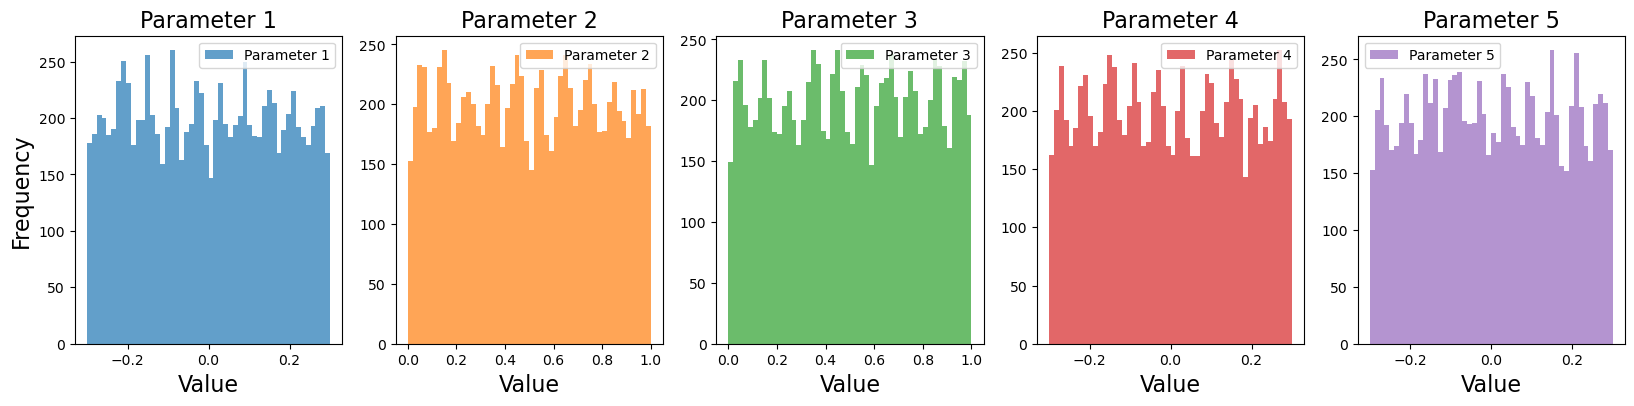

In [17]:
# Visualize the parameters
import matplotlib.pyplot as plt
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.figure(figsize=(20, 4))
for i in range(params.shape[1]):
    plt.subplot(1, 5, i+1)
    plt.hist(params[:,i], bins=50, alpha=0.7, color = colors[i])
    plt.title(f'Parameter {i+1}', fontsize=16)
    plt.xlabel('Value', fontsize=16)
    if i == 0:
        plt.ylabel('Frequency', fontsize=16)
    plt.legend([f'Parameter {i+1}'])

Param 1: mean -0.0021074197720736265, std 0.1724698543548584
Param 2: mean 0.49823325872421265, std 0.28808146715164185
Param 3: mean 0.5045260190963745, std 0.28825896978378296
Param 4: mean -0.0003062049800064415, std 0.17335641384124756
Param 5: mean 0.00013943591329734772, std 0.1715666502714157


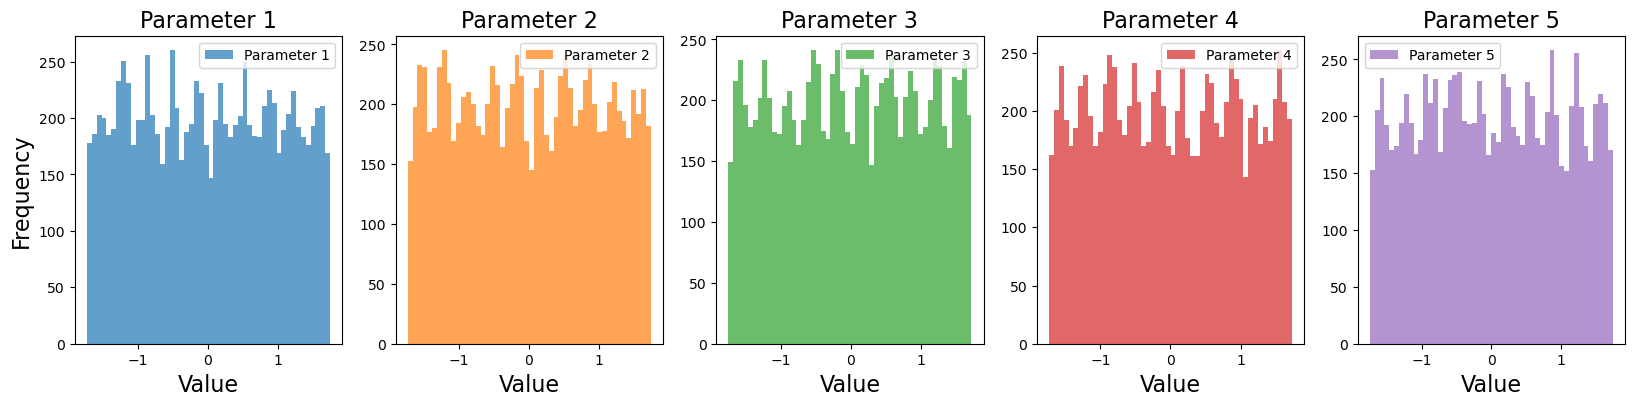

In [18]:
# Normalize function
def normalize_params(params):
    for i in range(params.shape[1]):
        mu_params = params[:,i].mean()
        std_params = params[:,i].std()
        print(f"Param {i+1}: mean {mu_params}, std {std_params}")
        params[:,i] = (params[:,i] - mu_params) / std_params
    return params

# Denormalize function
def denormalize_params(norm_params, mu_params, std_params):
    return norm_params * std_params + mu_params

# Normalize the parameters
params_norm = normalize_params(params.copy())

# Visualize the parameters
import matplotlib.pyplot as plt
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.figure(figsize=(20, 4))
for i in range(params_norm.shape[1]):
    plt.subplot(1, 5, i+1)
    plt.hist(params_norm[:,i], bins=50, alpha=0.7, color = colors[i])
    plt.title(f'Parameter {i+1}', fontsize=16)
    plt.xlabel('Value', fontsize=16)
    if i == 0:
        plt.ylabel('Frequency', fontsize=16)
    plt.legend([f'Parameter {i+1}'])

In [ ]:
# Normalize the parameters
scalars_norm = normalize_params(scalars.copy())

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)

for i in range(15):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    ax.hist(scalars_norm[:, i], bins=50, alpha=0.7)
    ax.set_title(f'Scalar {i+1}', fontsize=14)
    ax.set_xlabel('Value', fontsize=14)
    if c == 0:
        ax.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

In [44]:
# some stats
for i in range(4):
    min_images, max_images = dataset_icf_norm[..., i].min(), dataset_icf_norm[..., i].max()
    print(f"images: min {min_images}, max {max_images}")

for j in range(5):
    min_params, max_params = params_norm[..., j].min(), params_norm[..., j].max()
    print(f"params: min {min_params}, max {max_params}")

for k in range(15):
    min_scalars, max_scalars = scalars_norm[..., k].min(), scalars_norm[..., k].max()
    print(f"scalars: min {min_scalars}, max {max_scalars}")

images: min -1.4099277257919312, max 0.5833015441894531
images: min -1.4099277257919312, max 0.7032453417778015
images: min -1.4099277257919312, max 0.8155412673950195
images: min -1.4099277257919312, max 0.9183871746063232
params: min -1.7271806001663208, max 1.7516186237335205
params: min -1.7294796705245972, max 1.741719365119934
params: min -1.7502179145812988, max 1.7188307046890259
params: min -1.728737711906433, max 1.7322838306427002
params: min -1.7493693828582764, max 1.7477437257766724


NameError: name 'scalars_norm' is not defined

#### Set Up Dataloaders

In [ ]:
# data-scarce and compute-scarce scenarios
data_fraction = 1.0  # fraction of the data to use
dataset_size = int(dataset_icf_norm.shape[0] * data_fraction)  # adjust as needed
data_idx = np.random.choice(dataset_icf_norm.shape[0], dataset_size, replace=False)

In [ ]:
# Device information
import torch
print("Number of CUDA devices",torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Number of CUDA devices 2
Device: cuda


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# dataset class
class DatasetforDataloader(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        # create a tuple
        return self.X[i], self.y[i]
    
# Dataset of dataloader
X = dataset_icf_norm[data_idx]
y = params_norm[data_idx]
full_dataset = DatasetforDataloader(X, y)

# define the splits (80/10/10)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset 
train, val, test = torch.utils.data.random_split(full_dataset,[train_size, val_size, test_size])


In [ ]:
# Dataloaders
BATCH_SIZE = 8
dataloader_train = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val, batch_size = BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)
print(f"Number of training samples: {len(dataloader_train)}")
print(f"Number of validation samples: {len(dataloader_val)}")
print(f"Number of test samples: {len(dataloader_test)}")

Number of training samples: 1000
Number of validation samples: 125
Number of test samples: 125


### Define Models

##### Load MORPH

In [ ]:
# Instantiate the foundational model
from src.utils.vit_conv_xatt_axialatt2 import ViT3DRegression

model_variant = 'S'

MORPH_MODELS = {
    'Ti': [8, 256,  4,  4, 1024],
    'S' : [8, 512,  8,  4, 2048],
    'M' : [8, 768, 12,  8, 3072],
    'L' : [8, 1024,16, 16, 4096]
    }

model_size = MORPH_MODELS[model_variant]  # choose from 'Ti', 'S', 'M', 'L'
filters, dim, depth, heads, mlp_dim = model_size
heads_xa = 32
dropout = 0.1
emb_dropout = 0.1
max_ar_order = 1
patch_size = 8
max_patches = 4096
max_fields = 3
max_components = 3

# lora settings
rank_lora_attn = 16
rank_lora_mlp = 16
lora_p = 0.05

morph = ViT3DRegression(patch_size=patch_size, dim=dim, depth=depth,
    heads=heads, heads_xa=heads_xa, mlp_dim=mlp_dim,
    max_components=max_components, conv_filter=filters,
    max_ar=max_ar_order,
    max_patches=max_patches, max_fields=max_fields,
    dropout=dropout, emb_dropout=emb_dropout,
    lora_r_attn=rank_lora_attn,            # <— rank of A and B in the attention module
    lora_r_mlp=rank_lora_mlp,              # <— rank of A and B in the MLP module
    lora_alpha=None,                       # defaults to 2*rank inside LoRA
    lora_p=lora_p                          # dropout on LoRA path
).to(device)

# print('Model architecture:', ft_model)
num_params_model = sum(p.numel() for p in morph.parameters()) / 1e6
print(f"→ NUMBER OF PARAMETERS OF THE MODEL (in M): {num_params_model:.3g}")


→ NUMBER OF PARAMETERS OF THE MODEL (in M): 60.8


In [ ]:
# load the foundational model weights
from huggingface_hub import hf_hub_download

checkpoint_name = {'Ti':"morph-Ti-FM-max_ar1_ep225.pth", 
                   'S': "morph-S-FM-max_ar1_ep225.pth",
                   'M': "morph-M-FM-max_ar1_ep290_latestbatch.pth", 
                   'L': "morph-L-FM-max_ar16_ep189_latestbatch.pth"}

if os.path.join(model_dir, "FM", checkpoint_name[model_variant]) == True:
    weights_path = os.path.join(model_dir, "FM", checkpoint_name[model_variant])
else:
    # e.g., grab the "Ti" checkpoint (change filename as needed)
    weights_path = hf_hub_download(
        repo_id="mahindrautela/MORPH",
        filename=checkpoint_name[model_variant],
        subfolder="models/FM",
        repo_type="model",              # optional
        resume_download=True,           # continue if interrupted
        local_dir=".",         # where to place it
        local_dir_use_symlinks=False    # copy file instead of symlink
)
print(weights_path)

c:\Users\384861\AppData\Local\miniconda3\envs\pytorch_py38_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\384861\AppData\Local\miniconda3\envs\pytorch_py38_env\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\384861\AppData\Local\miniconda3\envs\pytorch_py38_env\lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out 

models\FM\morph-S-FM-max_ar1_ep225.pth


In [ ]:
#%% Load weights into the model
import torch.nn as nn

# ---- load the pretrained weights ----
start_epoch = 0
print(f"→ Loading checkpoints from {weights_path}")
# --- Load pretrained checkpoint from foundational model ---
ckpt = torch.load(weights_path, map_location=device, weights_only=True)
state_dict = ckpt["model_state_dict"]

# pick the real model if wrapped   
target = morph.module if isinstance(morph, nn.DataParallel) else morph 

if state_dict and next(iter(state_dict)).startswith("module."):
    print("→ Stripping 'module.' from checkpoints")
    state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}
    
# strict=False because ft_model has extra LoRA params (A/B) not in ckpt
missing, unexpected = target.load_state_dict(state_dict, strict=False)

# sanity print
print("Missing keys (expected: LoRA A/B etc.):",
        [k for k in missing if k.endswith((".A", ".B")) or ".lora" in k])
print("Unexpected keys:", unexpected)
print(f"→ Resumed from {weights_path}, starting at epoch {start_epoch}")


→ Loading checkpoints from models\FM\morph-S-FM-max_ar1_ep225.pth
→ Stripping 'module.' from checkpoints
Missing keys (expected: LoRA A/B etc.): ['transformer_blocks.0.axial_attn.attn_t.q.A', 'transformer_blocks.0.axial_attn.attn_t.q.B', 'transformer_blocks.0.axial_attn.attn_t.k.A', 'transformer_blocks.0.axial_attn.attn_t.k.B', 'transformer_blocks.0.axial_attn.attn_t.v.A', 'transformer_blocks.0.axial_attn.attn_t.v.B', 'transformer_blocks.0.axial_attn.attn_t.o.A', 'transformer_blocks.0.axial_attn.attn_t.o.B', 'transformer_blocks.0.axial_attn.attn_d.q.A', 'transformer_blocks.0.axial_attn.attn_d.q.B', 'transformer_blocks.0.axial_attn.attn_d.k.A', 'transformer_blocks.0.axial_attn.attn_d.k.B', 'transformer_blocks.0.axial_attn.attn_d.v.A', 'transformer_blocks.0.axial_attn.attn_d.v.B', 'transformer_blocks.0.axial_attn.attn_d.o.A', 'transformer_blocks.0.axial_attn.attn_d.o.B', 'transformer_blocks.0.axial_attn.attn_h.q.A', 'transformer_blocks.0.axial_attn.attn_h.q.B', 'transformer_blocks.0.axia

##### Task-specific head (TSH) (Simple CNN1D)

In [ ]:
# Calculate number of patches and features per patch
N_patches_W = X.shape[-2] // patch_size
N_patches_H = X.shape[-1] // patch_size
N_patches = N_patches_W * N_patches_H
feat_per_patch = patch_size * patch_size * X.shape[2] * X.shape[3]
print(f'Number of patches along W: {N_patches_W}, H: {N_patches_H}, Total Patches: {N_patches} \n'
      f'Feat_per_patch (patch_size * patch_size * C * F): {feat_per_patch}')

Number of patches along W: 8, H: 8, Total Patches: 64 
Feat_per_patch (patch_size * patch_size * C * F): 256


In [ ]:
# Task-specific head model
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class TaskSpecificHead_CNN1D(nn.Module):
    def __init__(self, n_patches=64, feat_dim=256, output_dim=5, dropout_p=0.1, take_params=False):
        super().__init__()
        self.n_patches = n_patches
        self.feat_dim = feat_dim

        self.conv1 = nn.Conv1d(in_channels=feat_dim, out_channels=feat_dim, kernel_size=3, stride = 2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=feat_dim, out_channels=feat_dim*2, kernel_size=3, stride = 2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=feat_dim*2, out_channels=feat_dim*4,  kernel_size=3, stride = 2, padding=1)

        self.act  = nn.GELU()
        self.drop = nn.Dropout(dropout_p)

        feat_len = n_patches // 8                         # 64 -> 8
        self.fc   = nn.Linear(feat_dim * 4 * feat_len, output_dim)  # 64*8 = 512

    def forward(self, x):
        B = x.shape[0]
        # reshape to (B, 64, 256) then permute to (B, 256, 64) for Conv1d
        #print(f"[TaskSpecificHead_CNN1D] Input x shape: {x.shape}")
        x = x.view(B, self.n_patches, self.feat_dim).permute(0, 2, 1).contiguous()
        #print(f"[TaskSpecificHead_CNN1D] Reshaped x shape: {x.shape}")
        x = self.act(self.conv1(x))  # (B, 256, 64)
        x = self.act(self.conv2(x))  # (B, 512,32)
        x = self.act(self.conv3(x))  # (B, 1024, 16)
        x = x.flatten(1)                        # (B, 1024*16 = 16384)
        x = self.drop(x)
        x = self.fc(x)                       # (B, output_dim)
        return x                       

class TaskSpecificHead_FC(nn.Module):
    def __init__(self, n_patches=64, feat_dim=256, output_dim=5, dropout_p=0.1):
        super().__init__()
        self.n_patches = n_patches
        self.feat_dim = feat_dim

        self.fc1 = nn.Linear(n_patches * feat_dim, feat_dim * 8)
        self.fc2 = nn.Linear(feat_dim * 8, feat_dim * 4)
        self.fc3 = nn.Linear(feat_dim * 4, feat_dim * 2)
        self.fc4 = nn.Linear(feat_dim * 2, feat_dim)
        self.fc5 = nn.Linear(feat_dim, output_dim)
        self.act  = nn.GELU()
        self.drop = nn.Dropout(dropout_p)
        self.norm = nn.LayerNorm(n_patches * feat_dim)

    def forward(self, x):
        B = x.shape[0]
        # reshape to (B, 64*256)
        #print(f"[TaskSpecificHead_FC] Input x shape: {x.shape}")
        x = x.view(B, self.n_patches * self.feat_dim).contiguous()
        #print(f"[TaskSpecificHead_FC] Reshaped x shape: {x.shape}")
        x = self.norm(x)
        x = self.drop(self.act(self.fc1(x))) 
        x = self.drop(self.act(self.fc2(x)))  
        x = self.drop(self.act(self.fc3(x)))  
        x = self.drop(self.act(self.fc4(x)))
        x = self.fc5(x)
        return x
    
# Instantiate the model - 1
output_dim = params.shape[1]  # number of parameters to predict
head = TaskSpecificHead_FC(n_patches = N_patches, feat_dim = dim, output_dim = output_dim).to(device)
print("Num params encoder (in K): ", sum(p.numel()//10**3 for p in head.parameters()))
print('Model architecture', head)

Num params encoder (in K):  145299
Model architecture TaskSpecificHead_FC(
  (fc1): Linear(in_features=32768, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=5, bias=True)
  (act): GELU(approximate='none')
  (drop): Dropout(p=0.1, inplace=False)
  (norm): LayerNorm((32768,), eps=1e-05, elementwise_affine=True)
)


In [ ]:
#%% Fine-tuning setup
from types import SimpleNamespace
from src.utils.select_fine_tuning_parameters import SelectFineTuningParameters

# defining arguments (similar to ft code)
def make_args(l1=False, l2=False, l3=False, l4=False, lr4=1e-4, wd4=1e-5):
    return SimpleNamespace(
        ft_level1=l1, ft_level2=l2, ft_level3=l3, ft_level4=l4,
        lr_level4=lr4, wd_level4=wd4
    )

# Level-1 and Level-2 only
args = make_args(l4 = True)
selector = SelectFineTuningParameters(morph, args)
optimizer_1 = selector.configure_levels()

→ Level-4 Finetuning (Full model) activated
[Level-4] unfrozen → full: 60.799M


In [ ]:
# Optimizer for head network
import torch.optim as optim
optimizer_2 = optim.Adam(head.parameters(), lr=5e-4, weight_decay=1e-5)

In [ ]:
# Loss function
num_epochs = 100  # adjust as needed
loss_fn = nn.MSELoss()

### Train/Finetune MORPH + TSH

In [ ]:
# Trainer class
class Trainer:
    @staticmethod
    def train_epoch(dataloader_train, model_1, model_2, optimizer_1, optimizer_2, device):
        model_1.train() 
        model_2.train()
        train_loss_1 = []
        train_loss_2 = []
        for step, batch in enumerate(dataloader_train):
            x_tr, y_tr = batch
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            #print(f'X: {x_tr.shape}, y: {y_tr.shape}')
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()

            # Model 1 forward + loss
            _, z, x_nsp = model_1(x_tr)
            #print(f"[Trainer] Model 1 output shape: {x_nsp.shape}")
            #print(f"[Trainer] Model 1 latent shape: {z.shape}")
            loss_1 = loss_fn(x_nsp.unsqueeze(1), x_tr) # autoencoder loss

            # Model 1 backward
            loss_1.backward()
            optimizer_1.step()
            train_loss_1.append(loss_1.item())

            # Model 2 forward + backward
            z = z.detach() # detach the two graphs
            y_hat = model_2(z.squeeze(1))
            #print(f"[Trainer] Model 2 output shape: {y_hat.shape}")
            loss_2 = loss_fn(y_hat, y_tr)
            loss_2.backward()
            optimizer_2.step()
            train_loss_2.append(loss_2.item())

        return np.mean(train_loss_1), np.mean(train_loss_2)

    @staticmethod
    def test_epoch(dataloader_val, model_1, model_2, device):
        model_1.eval() # Set the eval mode for model
        model_2.eval()
        test_loss_1 = []
        test_loss_2 = []
        with torch.no_grad(): # No need to track the gradients
            for step, batch in enumerate(dataloader_val):
                x_val, y_val = batch
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Model 1 forward
                _, z, x_nsp = model_1(x_val)
                loss_1 = loss_fn(x_nsp.unsqueeze(1), x_val)
                test_loss_1.append(loss_1.item())
                
                # Model 2 forward
                y_hat_2 = model_2(z.squeeze(1))
                loss_2 = loss_fn(y_hat_2, y_val)
                test_loss_2.append(loss_2.item())

        return np.mean(test_loss_1), np.mean(test_loss_2)

In [33]:
import time
diz_loss = {'train_loss_morph':[],'train_loss_head':[], 'val_loss_morph':[], 'val_loss_head':[]}
begin_time = time.time()
for epoch in range(num_epochs):
   train_loss_morph, train_loss_head = Trainer.train_epoch(dataloader_train, morph, head, 
                                                           optimizer_1, optimizer_2, device)
   val_loss_morph, val_loss_head = Trainer.test_epoch(dataloader_val, morph, head, device)

   print(
    f"\n EPOCH {epoch+1}/{num_epochs} TIME: {time.time()-begin_time:.2f}s, "
    f"train loss morph {train_loss_morph:.4f}, "
    f"val loss morph {val_loss_morph:.4f}, "
    f"train loss head {train_loss_head:.4f}, "
    f"val loss head {val_loss_head:.4f}"
)

   # store the losses per epoch
   diz_loss['train_loss_morph'].append(train_loss_morph)
   diz_loss['train_loss_head'].append(train_loss_head)
   diz_loss['val_loss_morph'].append(val_loss_morph)
   diz_loss['val_loss_head'].append(val_loss_head)

# Save the model
torch.save(morph.state_dict(), os.path.join(model_dir, 'morph_ft_icf.pth'))
torch.save(head.state_dict(), os.path.join(model_dir, 'head_ft_icf.pth'))


 EPOCH 1/100 TIME: 185.07s, train loss morph 0.0068, val loss morph 0.0014, train loss head 0.6901, val loss head 0.6420

 EPOCH 2/100 TIME: 359.47s, train loss morph 0.0021, val loss morph 0.0010, train loss head 0.6256, val loss head 0.5960

 EPOCH 3/100 TIME: 527.02s, train loss morph 0.0016, val loss morph 0.0010, train loss head 0.6144, val loss head 0.5914

 EPOCH 4/100 TIME: 696.44s, train loss morph 0.0014, val loss morph 0.0007, train loss head 0.6122, val loss head 0.5907

 EPOCH 5/100 TIME: 866.84s, train loss morph 0.0012, val loss morph 0.0007, train loss head 0.6079, val loss head 0.5972

 EPOCH 6/100 TIME: 1028.83s, train loss morph 0.0011, val loss morph 0.0006, train loss head 0.6041, val loss head 0.5937

 EPOCH 7/100 TIME: 1198.47s, train loss morph 0.0010, val loss morph 0.0005, train loss head 0.5998, val loss head 0.5867

 EPOCH 8/100 TIME: 1369.25s, train loss morph 0.0009, val loss morph 0.0006, train loss head 0.5953, val loss head 0.5806

 EPOCH 9/100 TIME: 1

##### Plot train vs val loss

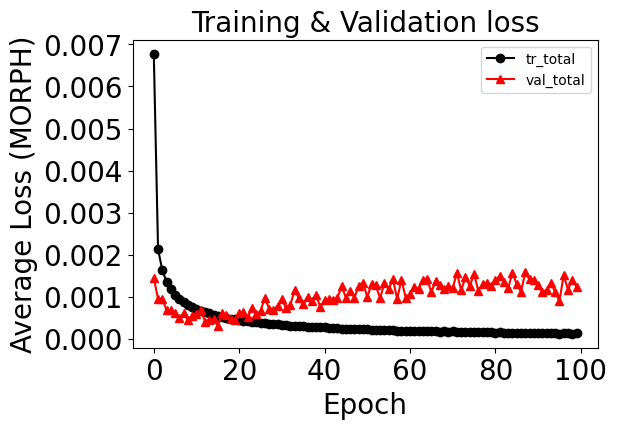

<Figure size 640x480 with 0 Axes>

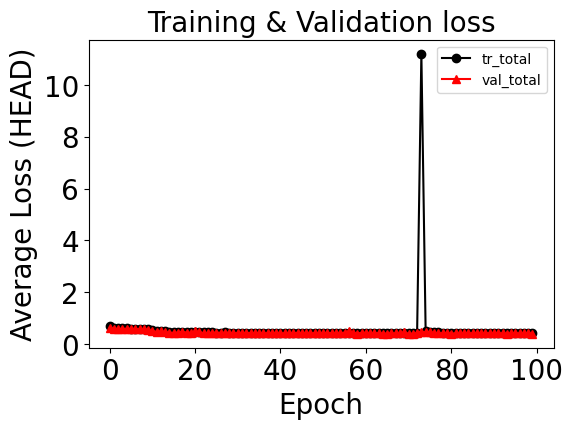

<Figure size 640x480 with 0 Axes>

In [34]:
# print train and val loss
plt.figure(figsize=(6, 4))
plt.plot(diz_loss['train_loss_morph'], '-ok', label='Train',)
plt.plot(diz_loss['val_loss_morph'], '-^r', label='Valid')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Average Loss (MORPH)',fontsize=20)
plt.legend(["tr_total", "val_total"])
plt.title('Training & Validation loss', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.savefig(os.path.join(results_dir, 'loss_ft_morph_icf.png'))


# print train and val loss
plt.figure(figsize=(6, 4))
plt.plot(diz_loss['train_loss_head'], '-ok', label='Train',)
plt.plot(diz_loss['val_loss_head'], '-^r', label='Valid')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Average Loss (HEAD)',fontsize=20)
plt.legend(["tr_total", "val_total"])
plt.title('Training & Validation loss', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.savefig(os.path.join(results_dir, 'loss_ft_head_icf.png'))

#### Testing MORPH + TSH on test set

In [35]:
# Testing
def testing(dataloader_test, model_1, model_2, device):
        model_1.eval() # Set the eval mode for model
        model_2.eval()
        mse_loss_1, mse_loss_2 = [], []
        x_org, x_pred, y_org, y_pred = [], [], [], []
        with torch.no_grad(): # No need to track the gradients
            for _, batch in enumerate(dataloader_test):
                x_test, y_test = batch
                x_test, y_test = x_test.to(device), y_test.to(device)

                # Model 1 forward
                _, z, x_nsp = model_1(x_test)
                loss_1 = loss_fn(x_nsp.unsqueeze(1), x_test)
                mse_loss_1.append(loss_1.item())
                
                # Model 2 forward
                y_hat_2 = model_2(z.squeeze(1))
                loss_2 = loss_fn(y_hat_2, y_test)
                mse_loss_2.append(loss_2.item())

                # Collect original and predicted samples
                x_org.append(x_test.cpu().numpy())
                x_pred.append(x_nsp.unsqueeze(1).cpu().numpy())
                y_org.append(y_test.cpu().numpy())
                y_pred.append(y_hat_2.cpu().numpy())

        return mse_loss_1, mse_loss_2, x_org, x_pred, y_org, y_pred

# get the test losses and predictions
mse_loss_main, mse_loss_head, x_org, x_pred, y_org, y_pred = testing(dataloader_test, morph, head, device)
print(f"Test Loss - Morph: {np.mean(mse_loss_main):.4f}, Head: {np.mean(mse_loss_head):.4f}")
print(f'x_org shape: {x_org[0].shape}, x_pred shape: {x_pred[0].shape}')
print(f'y_org shape: {y_org[0].shape}, y_pred shape: {y_pred[0].shape}')

Test Loss - Morph: 0.0012, Head: 0.4311
x_org shape: (8, 1, 4, 1, 1, 64, 64), x_pred shape: (8, 1, 4, 1, 1, 64, 64)
y_org shape: (8, 5), y_pred shape: (8, 5)


y_org shape: (1000, 5), y_pred shape: (1000, 5)
Parameter 1: R^2 = 0.0114, MSE = 0.9972
Parameter 2: R^2 = 0.9168, MSE = 0.0839
Parameter 3: R^2 = 0.9768, MSE = 0.0272
Parameter 4: R^2 = 0.0033, MSE = 1.0278
Parameter 5: R^2 = 0.9816, MSE = 0.0196


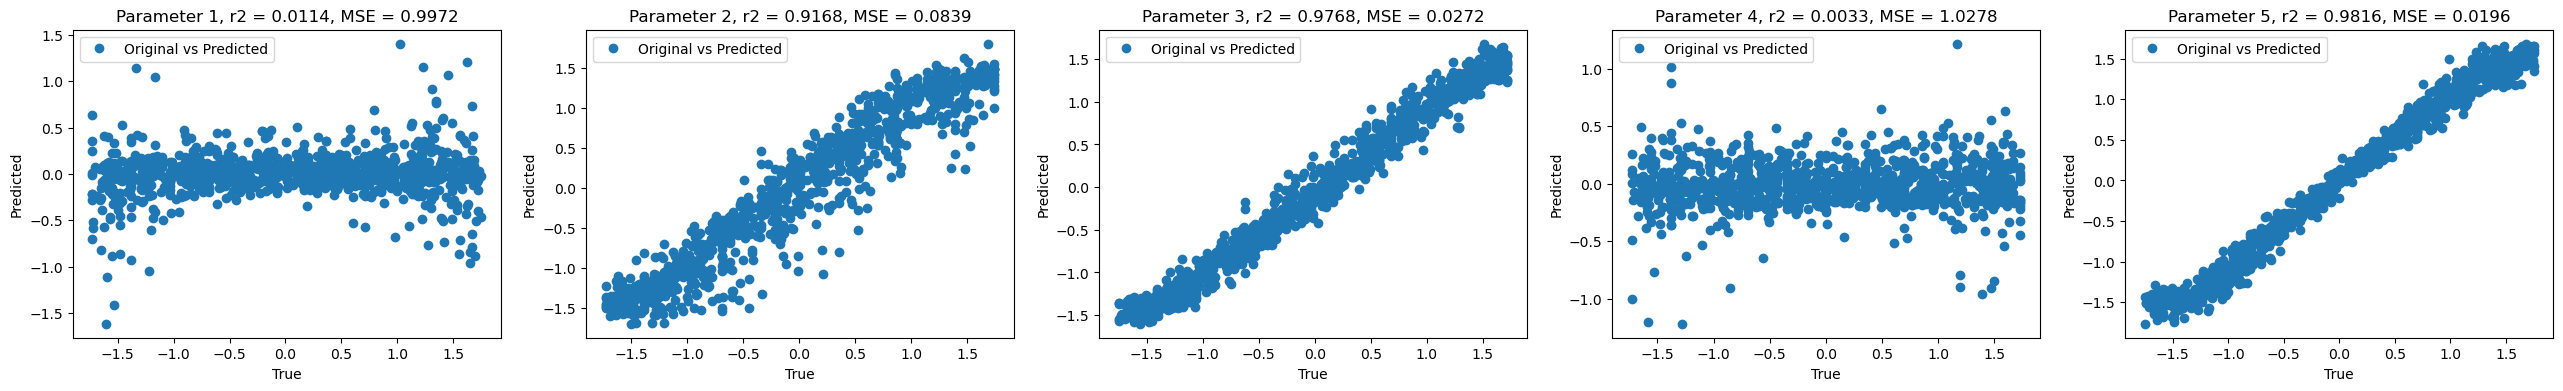

<Figure size 640x480 with 0 Axes>

In [36]:
# plot y_org vs y_pred
def plot_ytrue_vs_ypred(y_org, y_pred):
    y_org_arr = np.concatenate(y_org, axis=0)
    y_pred_arr =  np.concatenate(y_pred, axis=0)
    print(f'y_org shape: {y_org_arr.shape}, y_pred shape: {y_pred_arr.shape}')
    plt.figure(figsize=(32, 4))
    for c in range(y_org_arr.shape[1]):
        r2 = np.corrcoef(y_org_arr[:, c], y_pred_arr[:, c])[0, 1] ** 2
        mse = np.mean((y_org_arr[:, c] - y_pred_arr[:, c])**2)
        print(f'Parameter {c+1}: R^2 = {r2:.4f}, MSE = {mse:.4f}')
        plt.subplot(1, 5, c+1)
        plt.plot(y_org_arr[:, c], y_pred_arr[:, c], 'o', label='Original vs Predicted')
        plt.title(f'Parameter {c+1}, r2 = {r2:.4f}, MSE = {mse:.4f}')
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.legend()
    plt.show()
    plt.savefig(os.path.join(HERE, 'ytrue_vs_ypred.png'), dpi=300)

# plot for all parameters
plot_ytrue_vs_ypred(y_org, y_pred)

Number of test samples: 125, each of shape: (8, 1, 4, 1, 1, 64, 64)
Selected samples: [102  30 112  76  66]
x_org shape: (8, 4, 64, 64), x_pred shape: (8, 4, 64, 64)


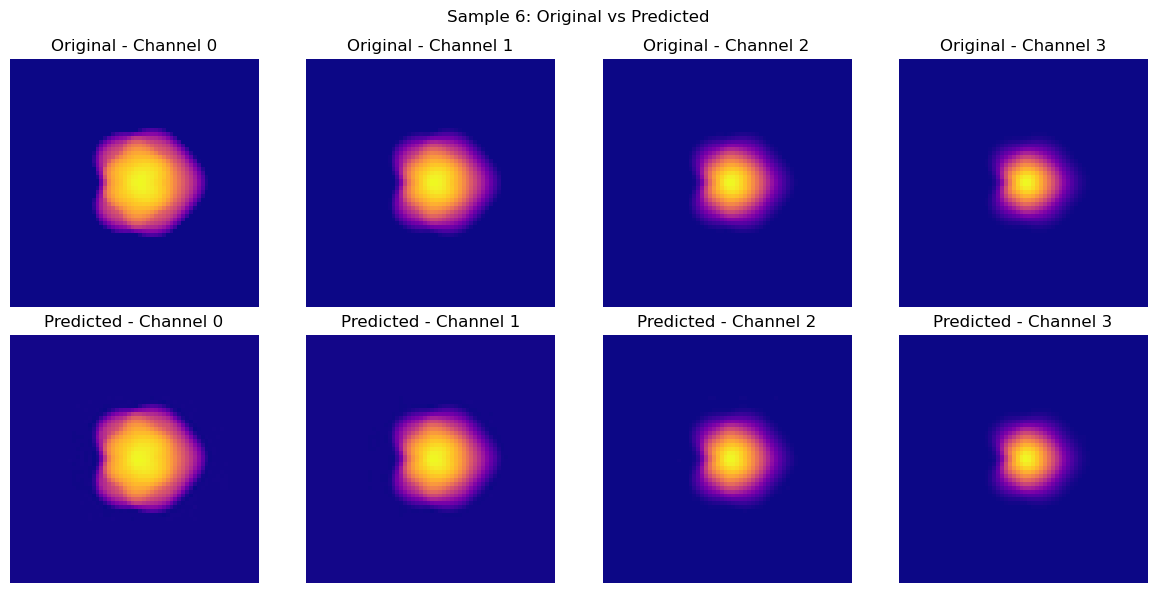

x_org shape: (8, 4, 64, 64), x_pred shape: (8, 4, 64, 64)


<Figure size 640x480 with 0 Axes>

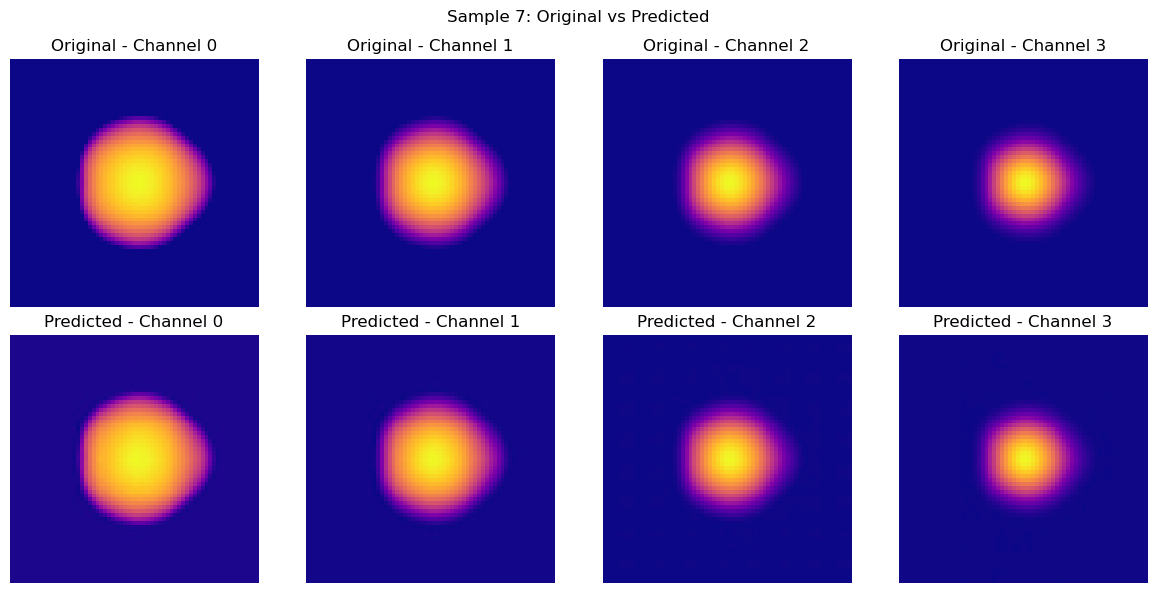

x_org shape: (8, 4, 64, 64), x_pred shape: (8, 4, 64, 64)


<Figure size 640x480 with 0 Axes>

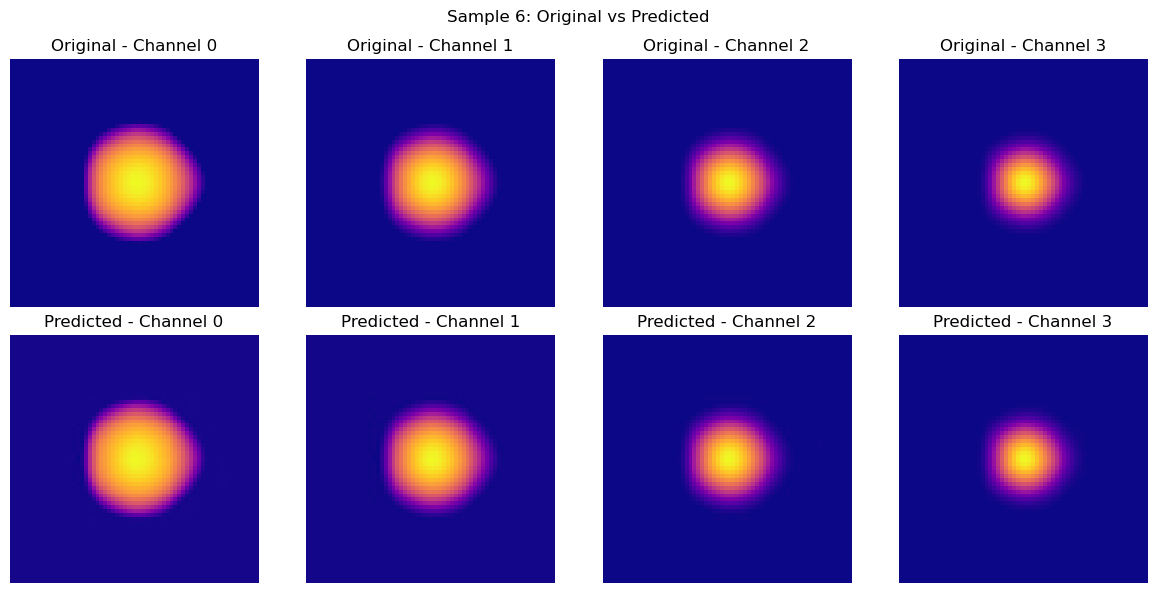

x_org shape: (8, 4, 64, 64), x_pred shape: (8, 4, 64, 64)


<Figure size 640x480 with 0 Axes>

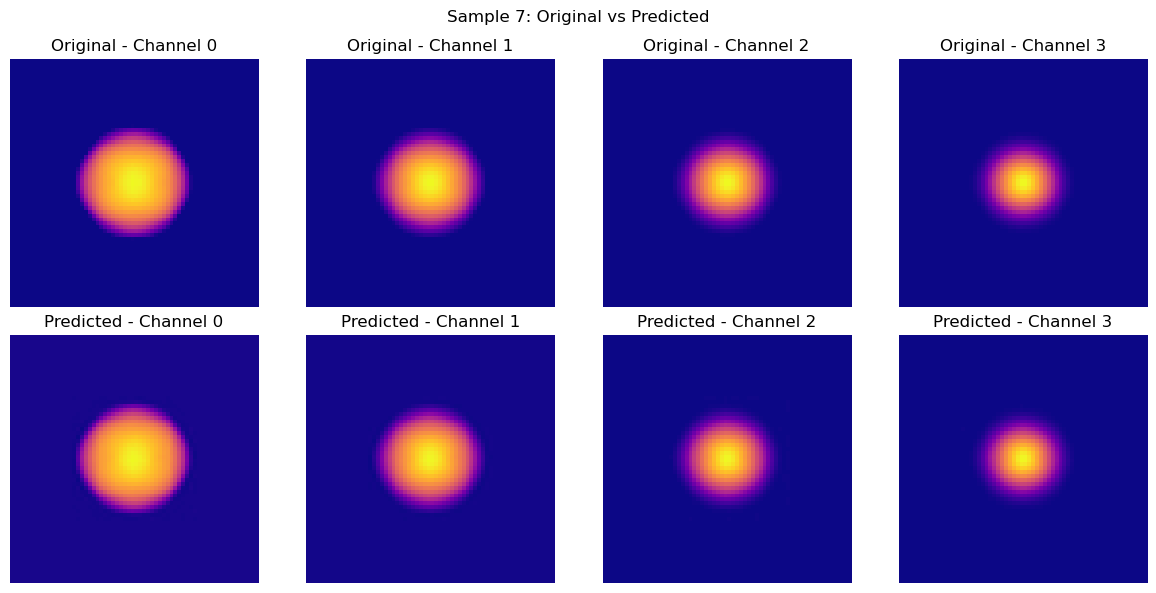

x_org shape: (8, 4, 64, 64), x_pred shape: (8, 4, 64, 64)


<Figure size 640x480 with 0 Axes>

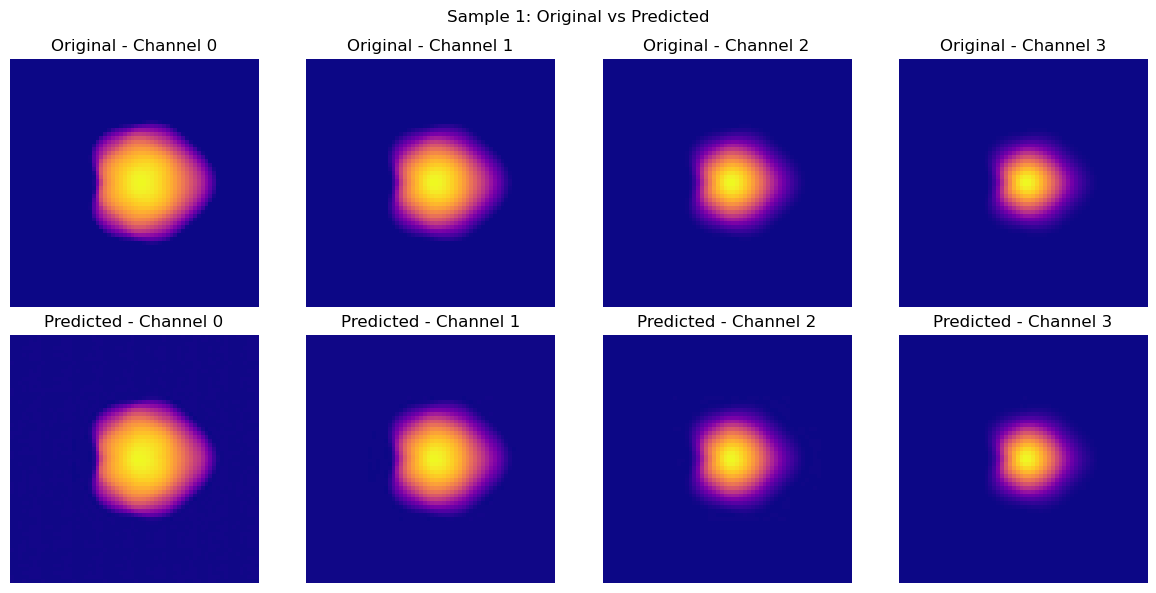

<Figure size 640x480 with 0 Axes>

In [37]:
# Plots of x_org vs x_pred
def plot_original_vs_predicted(x_org, x_pred):
    len_samples = len(x_org)
    print(f'Number of test samples: {len_samples}, each of shape: {x_org[0].shape}')
    select_samples = np.random.choice(len_samples, 5, replace=False)
    print(f'Selected samples: {select_samples}')

    for idx in select_samples:
        x_o = x_org[idx][:,0,:,:,0,:,:]       # (1, 2, 2, 1, 64, 64) -> (2, 2, 64, 64)
        x_p = x_pred[idx][:,0,:,:,0,:,:]      # (1, 2, 2, 1, 64, 64) -> (2, 2, 64, 64)
        x_o = x_o.reshape(-1, 4, 64, 64)      # (B, 4, 64, 64)
        x_p = x_p.reshape(-1, 4, 64, 64)      # (B, 4, 64, 64)
        print(f'x_org shape: {x_o.shape}, x_pred shape: {x_p.shape}')
        
        idx = np.random.randint(0, x_o.shape[0])  # pick a random sample from the batch
        x_o = x_o[idx]  # (4, 64, 64)
        x_p = x_p[idx]  # (4, 64, 64)

        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        for c in range(4):
            axes[0, c].imshow(x_o[c, :, :], cmap='plasma', origin='lower')
            axes[0, c].set_title(f'Original - Channel {c}')
            axes[0, c].axis('off')

            axes[1, c].imshow(x_p[c, :, :], cmap='plasma', origin='lower')
            axes[1, c].set_title(f'Predicted - Channel {c}')
            axes[1, c].axis('off')
        plt.suptitle(f'Sample {idx}: Original vs Predicted')
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(HERE, f'original_vs_predicted_sample_{idx}.png'), dpi=300)

plot_original_vs_predicted(x_org, x_pred)

## Standalone Model on ICF data

#### Standalone surrogate (SS): CNN2D encoder for regression

In [38]:
# Standalone model
import torch.nn as nn

class Standalone_CNN2D(nn.Module):
    def __init__(self, output_dim=5):
        super(Standalone_CNN2D, self).__init__()
        # 64x64 input with 4 channels
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1, padding=1)   # -> 32 x 64 x 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)  # -> 64 x 32 x 32
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1) # -> 128 x 16 x 16
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1) # -> 256 x 8 x 8

        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        self.flatten = nn.Flatten()

        # After three 2x2 pools: 64 -> 32 -> 16 -> 8
        # So features = 256 * 8 * 8 = 16384
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.activation(self.conv1(x))  # 32 x 64 x 64
        x = self.activation(self.conv2(x))  # 64 x 32 x 32
        x = self.activation(self.conv3(x))  # 128 x 16 x 16
        x = self.activation(self.conv4(x))  # 256 x 8 x 8
        x = self.flatten(x)                  # flatten
        x = self.activation(self.fc1(x))    # 256
        x = self.dropout(x)
        return self.fc2(x)                              # logits of shape (B, output_dim)

# Instantiate the model - 2
output_dim = params.shape[1]  # number of parameters to predict
model_ss = Standalone_CNN2D(output_dim).to(device)
print("Num params encoder (in M): ", sum(p.numel()//10**6 for p in model_ss.parameters()))
print('Model architecture', model_ss)

Num params encoder (in M):  4
Model architecture Standalone_CNN2D(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (activation): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


#### Training SS (CNN2D)

In [39]:
# Trainer class
class Trainer2:
    @staticmethod
    def train_epoch_ss(dataloader_train, model, optimizer, device):
        model.train() 
        train_loss = []
        for step, batch in enumerate(dataloader_train):
            x_tr, y_tr = batch
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            # print(f'X: {x_tr.shape}, y: {y_tr.shape}')
            # reshape x_tr
            x_tr = x_tr[:, 0, :, :, 0, :, :].reshape(-1, 4, 64, 64)  # (B,T,F,C,D,H,W) -> (B, 4, 64, 64)
            # print(f'X: {x_tr.shape}, y: {y_tr.shape}')

            optimizer.zero_grad()

            # Model 1 forward + loss
            y_hat = model(x_tr)
            loss = loss_fn(y_hat, y_tr) 

            # Model 1 backward
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        return np.mean(train_loss)

    @staticmethod
    def test_epoch_ss(dataloader_val, model, device):
        model.eval() # Set the eval mode for model
        test_loss = []
        with torch.no_grad(): # No need to track the gradients
            for step, batch in enumerate(dataloader_val):
                x_val, y_val = batch
                x_val, y_val = x_val.to(device), y_val.to(device)

                # print(f'X: {x_tr.shape}, y: {y_tr.shape}')
                # reshape x_tr
                x_val = x_val[:, 0, :, :, 0, :, :].reshape(-1, 4, 64, 64)  # (B,T,F,C,D,H,W) -> (B, 4, 64, 64)
                # print(f'X: {x_val.shape}, y: {y_val.shape}')

                # Modelforward
                y_hat = model(x_val)
                loss = loss_fn(y_hat, y_val)
                test_loss.append(loss.item())

        return np.mean(test_loss)

In [40]:
import time
diz_loss_ss = {'train_loss':[], 'val_loss':[]}
begin_time = time.time()
for epoch in range(num_epochs):
   train_loss = Trainer2.train_epoch_ss(dataloader_train, model_ss, optimizer_2, device)
   val_loss = Trainer2.test_epoch_ss(dataloader_val, model_ss, device)

   print(
    f"\n EPOCH {epoch+1}/{num_epochs} TIME: {time.time()-begin_time:.2f}s, "
    f"train loss {train_loss:.4f}, "
    f"val loss {val_loss:.4f}"
)

   # store the losses per epoch
   diz_loss_ss['train_loss'].append(train_loss)
   diz_loss_ss['val_loss'].append(val_loss)

# Save the model
torch.save(model_ss.state_dict(), os.path.join(model_dir, 'model_ss_icf.pth'))


 EPOCH 1/100 TIME: 3.17s, train loss 1.0011, val loss 1.0035

 EPOCH 2/100 TIME: 5.97s, train loss 1.0011, val loss 1.0035

 EPOCH 3/100 TIME: 8.86s, train loss 1.0011, val loss 1.0035

 EPOCH 4/100 TIME: 11.77s, train loss 1.0011, val loss 1.0035

 EPOCH 5/100 TIME: 14.51s, train loss 1.0011, val loss 1.0035

 EPOCH 6/100 TIME: 17.26s, train loss 1.0011, val loss 1.0035

 EPOCH 7/100 TIME: 20.12s, train loss 1.0011, val loss 1.0035

 EPOCH 8/100 TIME: 22.88s, train loss 1.0011, val loss 1.0035

 EPOCH 9/100 TIME: 25.67s, train loss 1.0011, val loss 1.0035

 EPOCH 10/100 TIME: 28.48s, train loss 1.0011, val loss 1.0035

 EPOCH 11/100 TIME: 31.27s, train loss 1.0011, val loss 1.0035

 EPOCH 12/100 TIME: 34.07s, train loss 1.0011, val loss 1.0035

 EPOCH 13/100 TIME: 36.85s, train loss 1.0011, val loss 1.0035

 EPOCH 14/100 TIME: 39.67s, train loss 1.0011, val loss 1.0035

 EPOCH 15/100 TIME: 42.41s, train loss 1.0011, val loss 1.0035

 EPOCH 16/100 TIME: 45.13s, train loss 1.0011, val 

##### plot training and val loss for SS

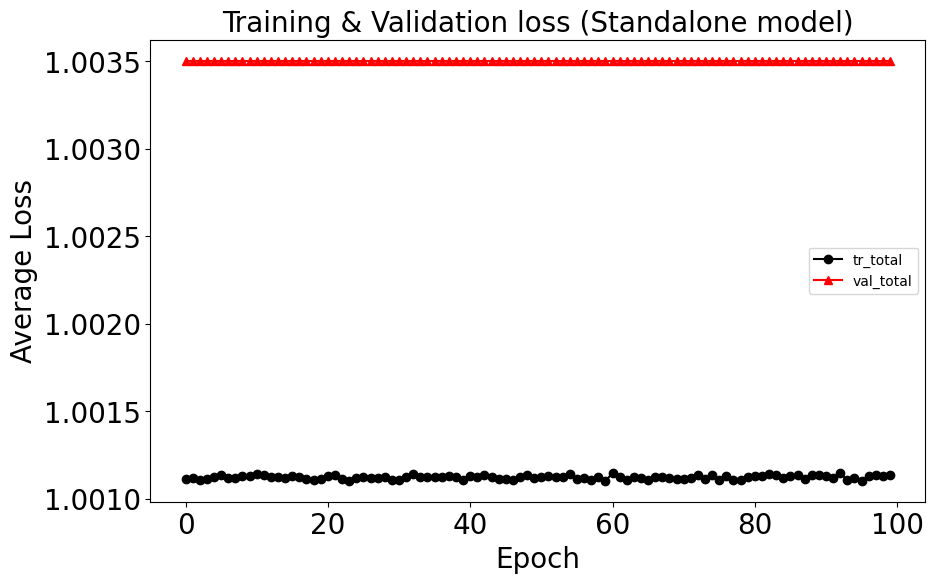

<Figure size 640x480 with 0 Axes>

In [41]:
# print train and val loss
plt.figure(figsize=(10, 6))
plt.plot(diz_loss_ss['train_loss'], '-ok', label='Train',)
plt.plot(diz_loss_ss['val_loss'], '-^r', label='Valid')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Average Loss',fontsize=20)
plt.legend(["tr_total", "val_total"])
plt.title('Training & Validation loss (Standalone model)', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.savefig(os.path.join(results_dir, 'loss_ss_icf.png'))

#### Testing SS on test set

In [42]:
# Testing
def testing_ss(dataloader_test, model, device):
        model.eval() # Set the eval mode for model
        test_loss = []
        y_org, y_pred = [], []
        with torch.no_grad(): # No need to track the gradients
            for _, batch in enumerate(dataloader_test):
                x_test, y_test = batch
                x_test, y_test = x_test.to(device), y_test.to(device)

                # print(f'X: {x_tr.shape}, y: {y_tr.shape}')
                # reshape x_tr
                x_test = x_test[:, 0, :, :, 0, :, :].reshape(-1, 4, 64, 64)  # (B,T,F,C,D,H,W) -> (B, 4, 64, 64)
                # print(f'X: {x_test.shape}, y: {y_test.shape}')

                # Model forward
                y_hat = model(x_test)
                loss = loss_fn(y_hat, y_test)
                test_loss.append(loss.item())

                # Collect original and predicted samples
                y_org.append(y_test.cpu().numpy())
                y_pred.append(y_hat.cpu().numpy())

        return test_loss, y_org, y_pred

# get the test losses and predictions
test_losses_ss, y_org_ss, y_pred_ss = testing_ss(dataloader_test, model_ss, device)
print(f'y_org shape: {y_org_ss[0].shape}, y_pred shape: {y_pred_ss[0].shape}')

y_org shape: (8, 5), y_pred shape: (8, 5)


y_org shape: (1000, 5), y_pred shape: (1000, 5)
Parameter 1: R^2 = 0.0022, MSE = 0.9928
Parameter 2: R^2 = 0.2408, MSE = 1.0102
Parameter 3: R^2 = 0.0196, MSE = 1.0167
Parameter 4: R^2 = 0.0021, MSE = 1.0088
Parameter 5: R^2 = 0.8175, MSE = 1.0125


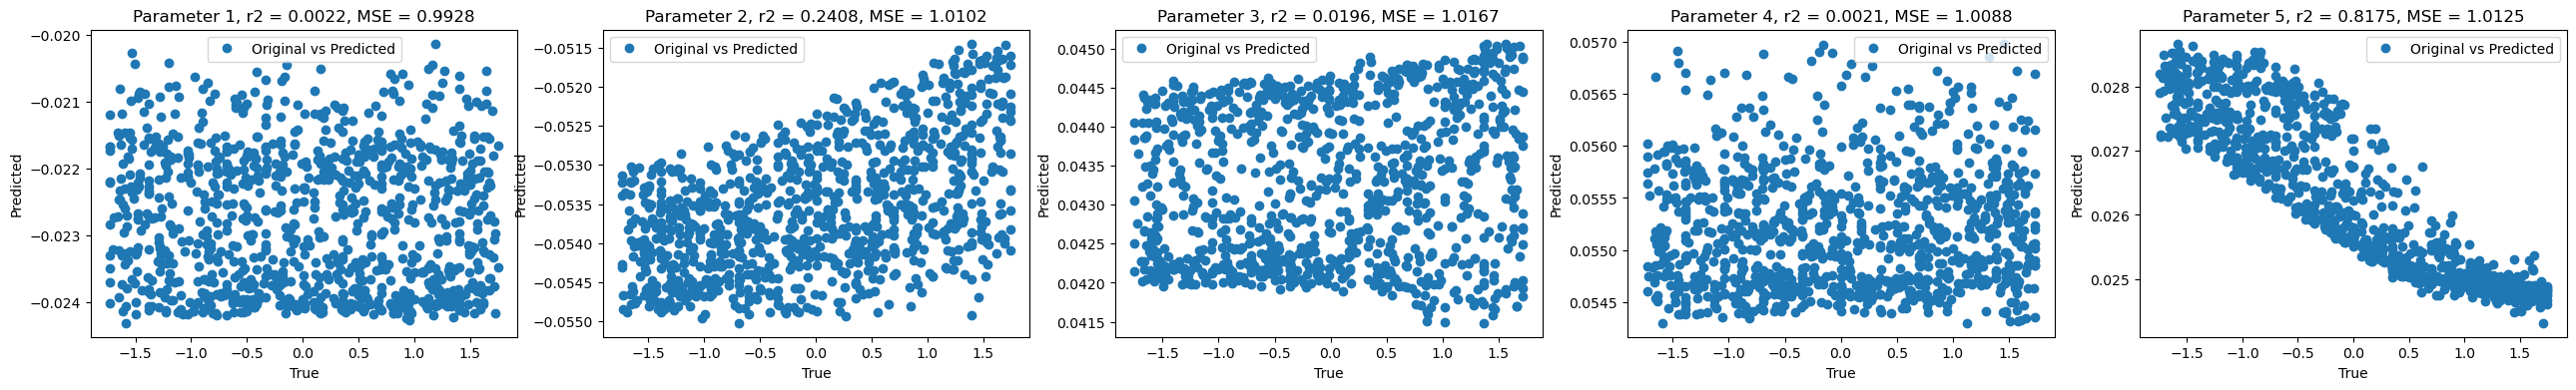

<Figure size 640x480 with 0 Axes>

In [43]:
# plot for all parameters
plot_ytrue_vs_ypred(y_org_ss, y_pred_ss)